In [10]:
# imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.calibration import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df_initial = pd.read_csv('ecommerce_customer_data_custom_ratios.csv',encoding="ISO-8859-1",
                         dtype={'Customer ID': str})

In [4]:
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (250000, 13)


In [5]:
df_initial['Purchase Date'] = pd.to_datetime(df_initial['Purchase Date'])

In [8]:
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}),
                     pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index={0: 'null values (%)'})])

display(tab_info)

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
column type,object,datetime64[ns],object,int64,int64,int64,object,int64,float64,object,int64,object,int64
null values (nb),0,0,0,0,0,0,0,0,47596,0,0,0,0
null values (%),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,19.038,0.000,0.000,0.000,0.000


In [9]:
# show first lines
display(df_initial[:5])

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.000,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.000,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.000,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.000,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.000,James Grant,49,Female,1


In [11]:
label_encoder = LabelEncoder()
df_initial['Gender'] = label_encoder.fit_transform(df_initial['Gender'])

In [12]:
display(df_initial[:5])

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.000,Christine Hernandez,37,1,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.000,Christine Hernandez,37,1,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.000,Christine Hernandez,37,1,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.000,Christine Hernandez,37,1,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.000,James Grant,49,0,1


In [13]:
print('Entrées dupliquées: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Entrées dupliquées: 0


In [14]:
df_initial = df_initial[df_initial["Returns"] != 1.000]

In [15]:
df_initial = df_initial.rename(columns={"Purchase Date": "Purchase_Date"})
df_initial = df_initial.rename(columns={"Customer ID": "Customer_ID"})
df_initial = df_initial.rename(columns={"Total Purchase Amount": "Total_Purchase_Amount"})
df_initial['Purchase_Date'] = pd.to_datetime(df_initial['Purchase_Date'])

In [16]:
display(df_initial[:5])

,Customer_ID,Purchase_Date,Product Category,Product Price,Quantity,Total_Purchase_Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.000,Christine Hernandez,37,1,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.000,Christine Hernandez,37,1,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.000,Christine Hernandez,37,1,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.000,Christine Hernandez,37,1,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.000,James Grant,49,0,1


In [30]:
df = df_initial

In [34]:
# Select relevant columns for segmentation
selected_columns = ['Product Price', 'Quantity', 'Total_Purchase_Amount', 'Customer Age', 'Gender']


In [35]:
# Extract features for clustering
X = df[selected_columns]

In [36]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

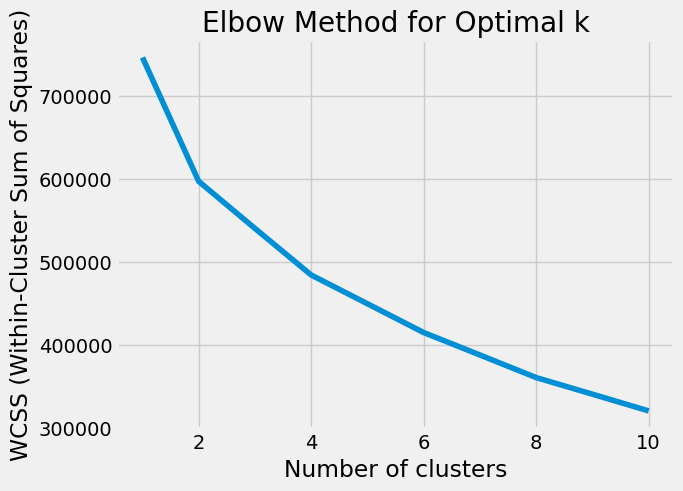

In [37]:
# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [38]:
# Based on the elbow method, choose the optimal number of clusters
optimal_clusters = 4

In [39]:

# Apply KMeans clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the resulting clusters
cluster_means = df.groupby('Cluster')[selected_columns].mean()
print(cluster_means)


         Product Price  Quantity  Total_Purchase_Amount  Customer Age  Gender
Cluster                                                                      
0              257.594     2.973               2496.347        30.887   0.000
1              256.454     2.984               2908.333        57.229   1.000
2              253.597     3.013               2536.701        30.809   1.000
3              252.505     3.018               2961.325        57.045   0.000


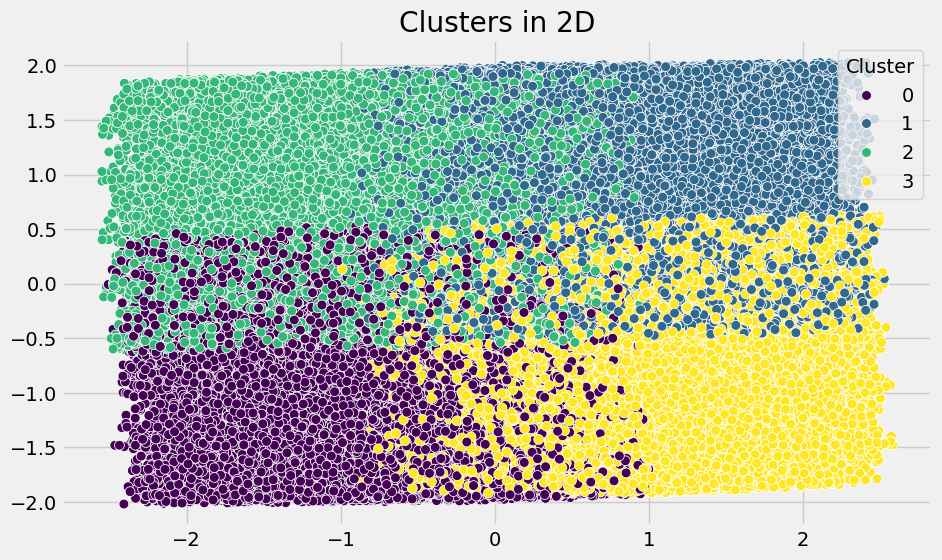

In [40]:
# Fit PCA to the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add cluster information to the DataFrame
df['Cluster'] = kmeans.labels_

# Plot clusters in 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=50)
plt.title('Clusters in 2D')
plt.show()

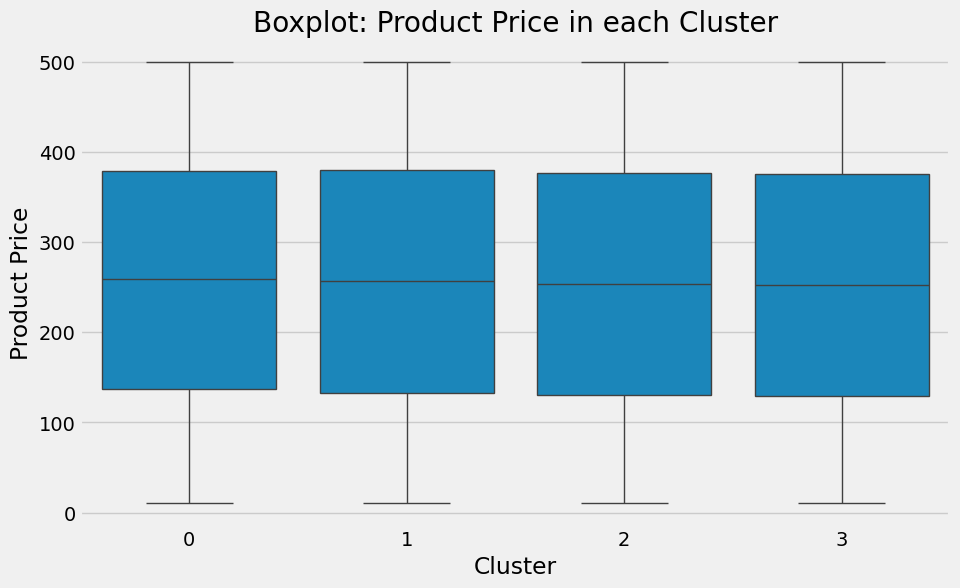

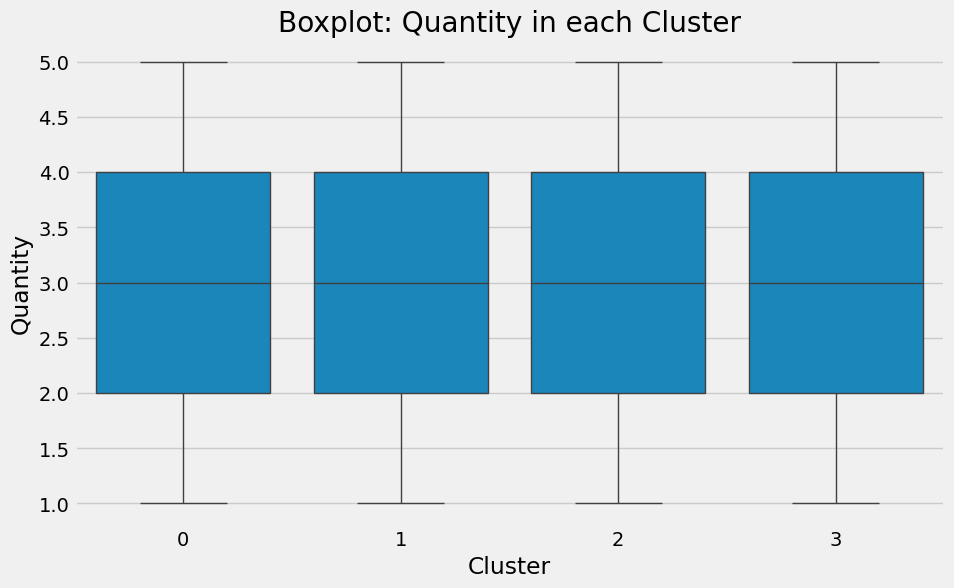

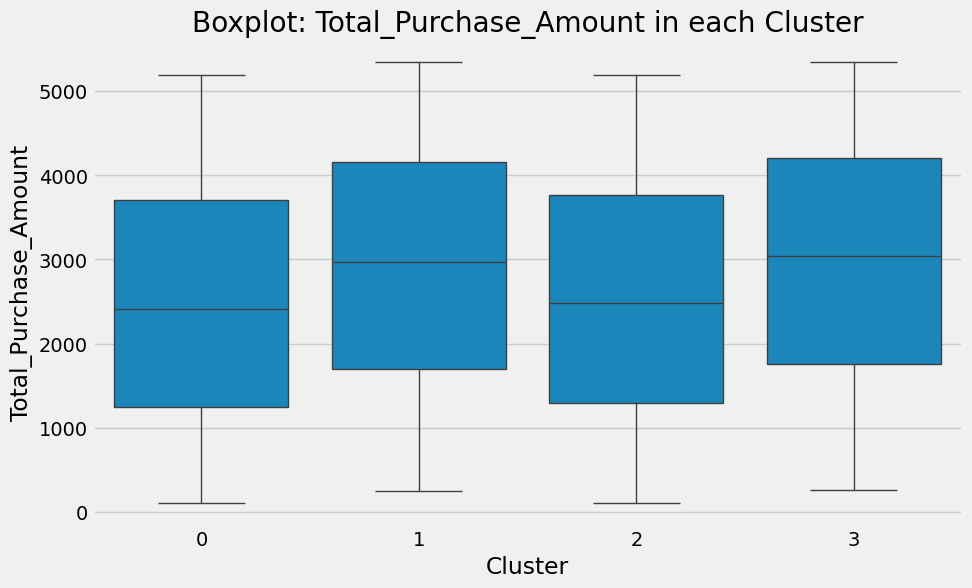

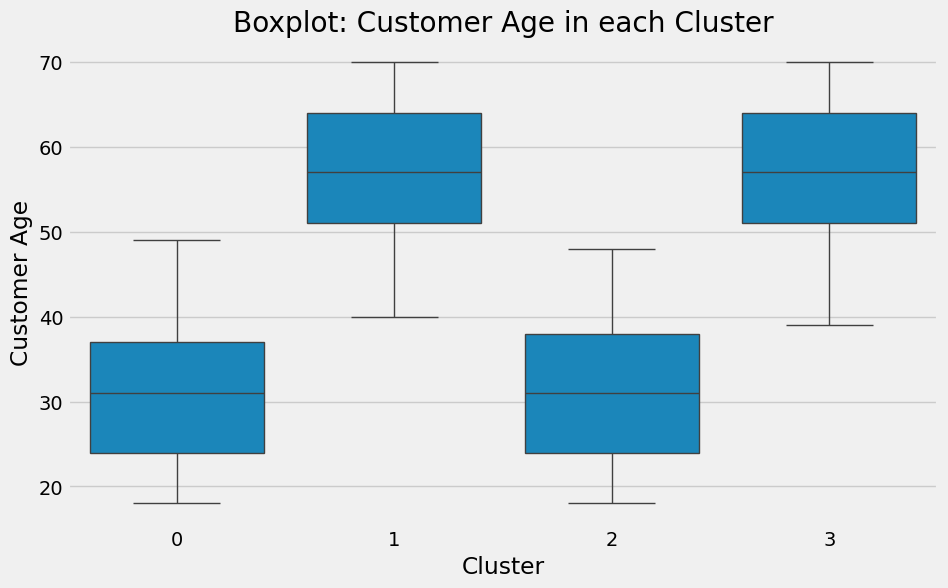

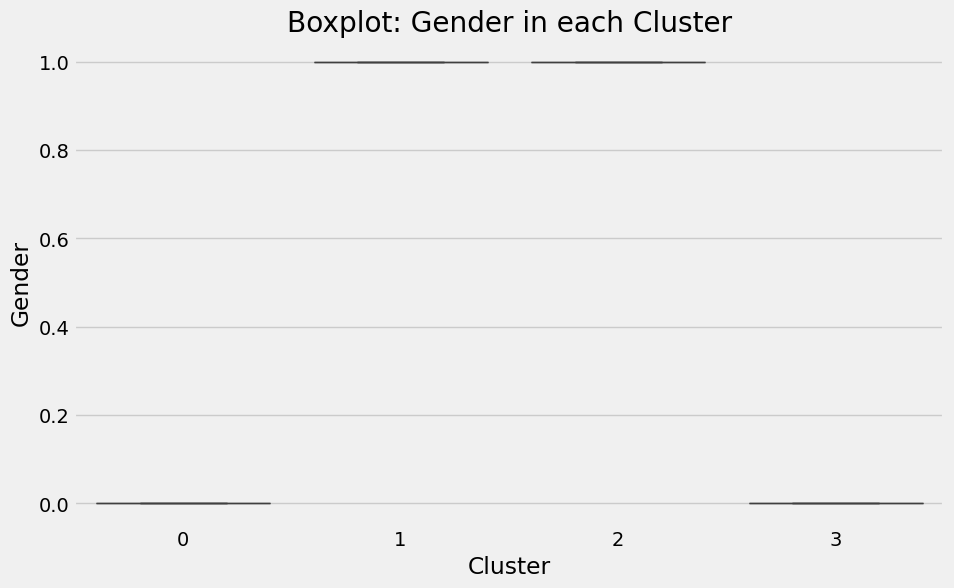

In [42]:
# Boxplot for each feature in each cluster
for feature in selected_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'Boxplot: {feature} in each Cluster')
    plt.show()


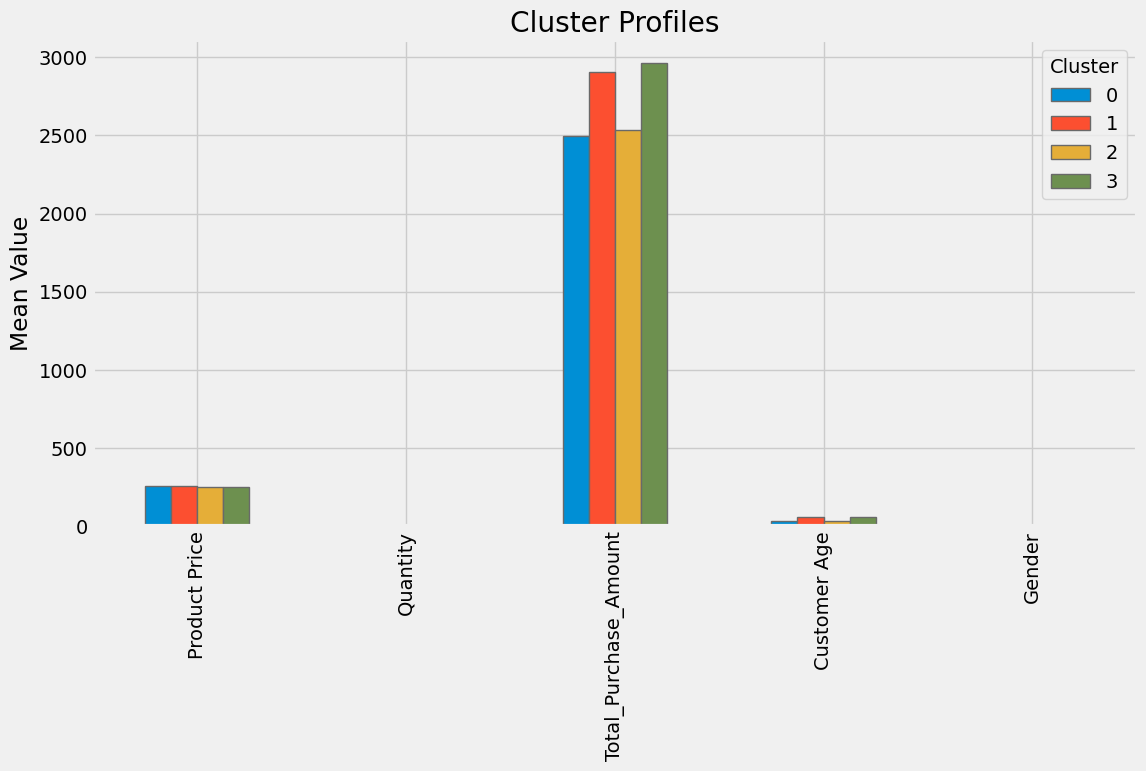

In [43]:
# Compute mean values for each feature in each cluster
cluster_means = df.groupby('Cluster')[selected_columns].mean()

# Plot cluster profiles
cluster_means.T.plot(kind='bar', figsize=(12, 6))
plt.title('Cluster Profiles')
plt.ylabel('Mean Value')
plt.show()